# DAT210x - Programming with Python for DS

## Module4- Lab2

In [78]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA 
import datetime
import numpy as np

from sklearn import preprocessing

In [79]:
# Look pretty...

# matplotlib.style.use('ggplot')
plt.style.use('ggplot')

### Some Boilerplate Code

For your convenience, we've included some boilerplate code here which will help you out. You aren't expected to know how to write this code on your own at this point, but it'll assist with your visualizations. We've added some notes to the code in case you're interested in knowing what it's doing:

### A Note on SKLearn's `.transform()` calls:

Any time you perform a transformation on your data, you lose the column header names because the output of SciKit-Learn's `.transform()` method is an NDArray and not a daraframe.

This actually makes a lot of sense because there are essentially two types of transformations:
- Those that adjust the scale of your features, and
- Those that change alter the number of features, perhaps even changing their values entirely.

An example of adjusting the scale of a feature would be changing centimeters to inches. Changing the feature entirely would be like using PCA to reduce 300 columns to 30. In either case, the original column's units have either been altered or no longer exist at all, so it's up to you to assign names to your columns after any transformation, if you'd like to store the resulting NDArray back into a dataframe.

In [80]:
def scaleFeaturesDF(df):
    # Feature scaling is a type of transformation that only changes the
    # scale, but not number of features. Because of this, we can still
    # use the original dataset's column names... so long as we keep in
    # mind that the _units_ have been altered:

    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    
    print("New Variances:\n", scaled.var())
    print("New Describe:\n", scaled.describe())
    return scaled

SKLearn contains many methods for transforming your features by scaling them, a type of pre-processing):
    - `RobustScaler`
    - `Normalizer`
    - `MinMaxScaler`
    - `MaxAbsScaler`
    - `StandardScaler`
    - ...

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

However in order to be effective at PCA, there are a few requirements that must be met, and which will drive the selection of your scaler. PCA requires your data is standardized -- in other words, it's _mean_ should equal 0, and it should have unit variance.

SKLearn's regular `Normalizer()` doesn't zero out the mean of your data, it only clamps it, so it could be inappropriate to use depending on your data. `MinMaxScaler` and `MaxAbsScaler` both fail to set a unit variance, so you won't be using them here either. `RobustScaler` can work, again depending on your data (watch for outliers!). So for this assignment, you're going to use the `StandardScaler`. Get familiar with it by visiting these two websites:

- http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

Lastly, some code to help with visualizations:

In [81]:
#ax = drawVectors(T, pca.components_, df.columns.values, plt, scaleFeatures)


def drawVectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes() # No cheating ;-)

    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

### And Now, The Assignment

In [82]:
# Do * NOT * alter this line, until instructed!
scaleFeatures = False

Load up the dataset specified on the lab instructions page and remove any and all _rows_ that have a NaN in them. You should be a pro at this by now ;-)

**QUESTION**: Should the `id` column be included in your dataset as a feature?

In [83]:
# .. your code here ..
df  = pd.read_csv('C:\\Users\\mirfa\\Desktop\\Irfan\\Datascience\\EDX\\DAT210x-master\\DAT210x-master\\Module4\\Datasets/kidney_disease.csv', sep=',', na_values=["?"])
df=df.dropna()
df=df.drop('id',axis =1)
df1=df

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd


Let's build some color-coded labels; the actual label feature will be removed prior to executing PCA, since it's unsupervised. You're only labeling by color so you can see the effects of PCA:

In [84]:
labels = ['red' if i=='ckd' else 'green' for i in df.classification]

Use an indexer to select only the following columns: `['bgr','wc','rc']`

In [85]:
# .. your code here ..
df=df[['bgr','wc','rc']]
df.head()


,bgr,wc,rc
3,117.0,6700,3.9
9,70.0,12100,3.7
11,380.0,4500,3.8
14,157.0,11000,2.6
20,173.0,9200,3.2


Either take a look at the dataset's webpage in the attribute info section of UCI's [Chronic Kidney Disease]() page,: https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease or alternatively, you can actually look at the first few rows of your dataframe using `.head()`. What kind of data type should these three columns be? Compare what you see with the results when you print out your dataframe's `dtypes`.

If Pandas did not properly detect and convert your columns to the data types you expected, use an appropriate command to coerce these features to the right type.

In [86]:
# .. your code here ..

df=df.apply(pd.to_numeric, errors='coerce')

df.describe()

,bgr,wc,rc
count,158.000000,158.000000,158.000000
mean,131.341772,8475.949367,4.891772
std,64.939832,3126.880181,1.019364
min,70.000000,3800.000000,2.100000
25%,97.000000,6525.000000,4.500000
50%,115.500000,7800.000000,4.950000
75%,131.750000,9775.000000,5.600000
max,490.000000,26400.000000,8.000000


PCA Operates based on variance. The variable with the greatest variance will dominate. Examine your data using a command that will check the variance of every feature in your dataset, and then print out the results. Also print out the results of running `.describe` on your dataset.

_Hint:_ If you do not see all three variables: `'bgr'`, `'wc'`, and `'rc'`, then it's likely you probably did not complete the previous step properly.

In [87]:
# .. your code here ..
df.var()

bgr    4.217182e+03
wc     9.777380e+06
rc     1.039104e+00
dtype: float64

Below, we assume your dataframe's variable is named `df`. If it isn't, make the appropriate changes. But do not alter the code in `scaleFeaturesDF()` just yet!

In [88]:
# .. your (possible) code adjustment here ..
if scaleFeatures: df = scaleFeaturesDF(df)
pca = PCA(n_components=2,svd_solver='full')
pca=pca.fit(df)
T = pca.transform(df)
pca = T
print(pca)





    

    


[[ -1.77599523e+03  -6.50884111e+00]
 [  3.62374523e+03  -7.73043491e+01]
 [ -3.97481492e+03   2.66180054e+02]
 [  2.52413939e+03   1.45475306e+01]
 [  7.24227321e+02   3.84761986e+01]
 [ -1.57609407e+03  -2.93866865e+01]
 [  1.12462435e+03   1.27705575e+02]
 [  1.04236792e+04  -1.07270983e+02]
 [ -1.27540082e+03   1.27281567e+02]
 [  6.12413081e+03   4.67849769e+00]
 [ -2.07593939e+03   6.81590301e+00]
 [ -2.27591987e+03   1.16936466e+01]
 [ -4.67614757e+03  -3.47166692e+01]
 [  1.32469291e+03   1.42823140e+02]
 [  4.02435810e+03   6.09177690e+01]
 [ -2.87553505e+03   1.00337891e+02]
 [ -1.47521371e+03   1.70168344e+02]
 [  6.72392658e+03  -4.29710106e+01]
 [ -3.47550712e+03   1.07986121e+02]
 [  7.82396011e+03  -3.78095415e+01]
 [ -7.60076971e+01  -1.30251074e+01]
 [  2.02391497e+03  -3.52564207e+01]
 [  6.72467582e+03   1.27032056e+02]
 [  6.12461556e+03   1.14677277e+02]
 [ -5.75984850e+02  -6.79741591e+00]
 [  2.42478357e+03   1.60974186e+02]
 [  4.32387950e+03  -4.83865898e+01]
 

Run PCA on your dataset, reducing it to 2 principal components. Make sure your PCA model is saved in a variable called `'pca'`, and that the results of your transformation are saved in another variable `'T'`:

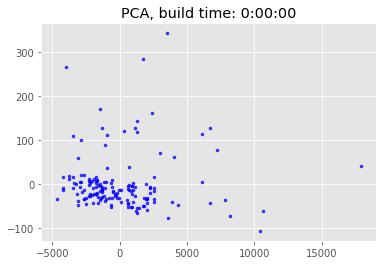

In [89]:
# .. your code here ..
t1 = datetime.datetime.now()
time_delta = datetime.datetime.now() - t1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('PCA, build time: ' + str(time_delta))
ax.scatter(pca[:,0], pca[:,1], c='blue', marker='.', alpha=0.75)

Now, plot the transformed data as a scatter plot. Recall that transforming the data will result in a NumPy NDArray. You can either use MatPlotLib to graph it directly, or you can convert it back to DataFrame and have Pandas do it for you.

Since we've already demonstrated how to plot directly with MatPlotLib in `Module4/assignment1.ipynb`, this time we'll show you how to convert your transformed data back into to a Pandas Dataframe and have Pandas plot it from there.

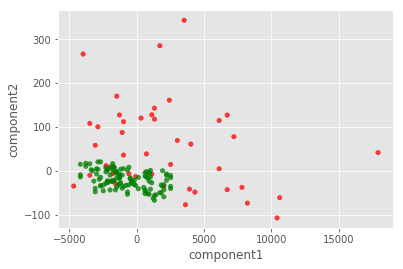

In [90]:
# Since we transformed via PCA, we no longer have column names; but we know we
# are in `principal-component` space, so we'll just define the coordinates accordingly:
ax = drawVectors(T, pca, df.columns.values, plt, scaleFeatures)
T  = pd.DataFrame(T)

T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)

plt.show()

In [91]:
df1.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,49.563291,74.050633,1.019873,0.797468,0.253165,131.341772,52.575949,2.188608,138.848101,4.636709,13.687342
std,15.512244,11.175381,0.005499,1.413130,0.813397,64.939832,47.395382,3.077615,7.489421,3.476351,2.882204
min,6.000000,50.000000,1.005000,0.000000,0.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000
25%,39.250000,60.000000,1.020000,0.000000,0.000000,97.000000,26.000000,0.700000,135.000000,3.700000,12.600000
50%,50.500000,80.000000,1.020000,0.000000,0.000000,115.500000,39.500000,1.100000,139.000000,4.500000,14.250000
75%,60.000000,80.000000,1.025000,1.000000,0.000000,131.750000,49.750000,1.600000,144.000000,4.900000,15.775000
max,83.000000,110.000000,1.025000,4.000000,5.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000


In [92]:
df1.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd


In [94]:
df1=df1.drop([ 'classification', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'] ,axis =1,inplace=true)

In [ ]:
df1.dtypes


In [ ]:
df1.pcv=pd.to_numeric(df1.pcv,errors='coerce')
df1.wc=pd.to_numeric(df1.wc,errors='coerce')
df1.rc=pd.to_numeric(df1.rc,errors='coerce')

In [ ]:
df1.dtypes()